# Relatorio da Etapa 3

Este relatorio foi feito em .ipynb para facilitar a demonstração do conhecimentos adquirido no lab_notebook, com isso é possivel identificar a partir que de nível de ruído, para cada modulação, o sistema começa a falhar. 

Este relatorio irá responder as questões da atividade fornecida:
- Identifique o valor de SNR onde os primeiros bits são comprometidos
- Identifique o valor de SNR onde os primeiros todos os bits são comprometidos
- Utilize graficos para ilustrar os resultados onde o eixo x representa o valor de SNR e o y o número de erros

OBS: A versão do formulario estará convertido em pdf.

## Setup

Esta etapa é essencial para o funcionamento do codigo, ela irá instalar as dependencias necessarias e criar as funções que serão utilizadas

In [3]:
%pip install numpy matplotlib sounddevice sounddevice scipy

import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

##
## Configurações globais do laboratório
##

output_device = 4
input_device = 1
sd.default.device = (input_device, output_device)

SAMPLE_RATE = 44100 
BIT_DURATION = 1.0   
FREQ_LOW = 440       
FREQ_HIGH = 880      

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Gerador de tom & visualizacao

In [4]:
def generate_tone(frequency, duration, sample_rate=SAMPLE_RATE):
    """
    Gera um tom senoidal
    
    Args:
        frequency: Frequência em Hz
        duration: Duração em segundos
        sample_rate: Taxa de amostragem
    
    Returns:
        array: Sinal de áudio
    """
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    # Aplica janela para suavizar transições
    tone = np.sin(2 * np.pi * frequency * t)
    # Janela de Hanning para evitar cliques
    window = np.hanning(len(tone))
    return tone * window

In [5]:
def show(data:str,debug):
    if debug==True:
        print(data)

In [6]:
def plot_signal(audio_signal, title, num_bits):
    time_axis = np.linspace(0, len(audio_signal)/SAMPLE_RATE, len(audio_signal))
    
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, audio_signal)
    plt.title(title)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    for i in range(1, num_bits): #divisões dos bits
        plt.axvline(x=i*BIT_DURATION, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

### Codificadores

In [7]:
def encode_nrz(data_bits,debug=False):
    """
    Codifica dados usando NRZ
    
    Args:
        data_bits: string de bits (ex: "10110")
    
    Returns:
        array: Sinal de áudio codificado
    """
    audio_signal = np.array([])
    
    show(f"Codificando NRZ: {data_bits}",debug)
    
    for i, bit in enumerate(data_bits):
        if bit == '1':
            freq = FREQ_HIGH
            show(f"Bit {i}: '1' -> {freq} Hz",debug)
        else:
            freq = FREQ_LOW
            show(f"Bit {i}: '0' -> {freq} Hz",debug)
        
        tone = generate_tone(freq, BIT_DURATION)
        audio_signal = np.concatenate([audio_signal, tone])
    
    return audio_signal

In [8]:
def encode_manchester(data_bits,debug=False):
    """
    Codifica dados usando Manchester
    
    Args:
        data_bits: string de bits
    
    Returns:
        array: Sinal de áudio codificado
    """
    audio_signal = np.array([])
    
    show(f"Codificando Manchester: {data_bits}",debug)
    
    for i, bit in enumerate(data_bits):
        if bit == '1':
            # Bit '1': alto->baixo (primeira metade alta, segunda baixa)
            tone1 = generate_tone(FREQ_HIGH, BIT_DURATION/2)
            tone2 = generate_tone(FREQ_LOW, BIT_DURATION/2)
            show(f"Bit {i}: '1' -> {FREQ_HIGH}Hz -> {FREQ_LOW}Hz",debug)
        else:
            # Bit '0': baixo->alto (primeira metade baixa, segunda alta)
            tone1 = generate_tone(FREQ_LOW, BIT_DURATION/2)
            tone2 = generate_tone(FREQ_HIGH, BIT_DURATION/2)
            show(f"Bit {i}: '0' -> {FREQ_LOW}Hz -> {FREQ_HIGH}Hz",debug)
        
        bit_signal = np.concatenate([tone1, tone2])
        audio_signal = np.concatenate([audio_signal, bit_signal])
    
    return audio_signal

### Decodificadores

In [9]:
def detect_frequency(audio_segment, sample_rate=SAMPLE_RATE):
    """
    Detecta a frequência dominante em um segmento de áudio
    
    Args:
        audio_segment: Segmento de áudio
        sample_rate: Taxa de amostragem
    
    Returns:
        float: Frequência detectada
    """
    # FFT para análise espectral
    fft = np.fft.fft(audio_segment)
    freqs = np.fft.fftfreq(len(fft), 1/sample_rate)
    
    # Considera apenas frequências positivas
    magnitude = np.abs(fft[:len(fft)//2])
    freqs_positive = freqs[:len(freqs)//2]
    
    # Encontra o pico de frequência
    peak_idx = np.argmax(magnitude)
    detected_freq = abs(freqs_positive[peak_idx])
    
    return detected_freq

def frequency_to_bit(frequency, threshold=660):
    """
    Converte frequência detectada em bit
    
    Args:
        frequency: Frequência detectada
        threshold: Limiar para decisão (média entre FREQ_LOW e FREQ_HIGH)
    
    Returns:
        str: '0' ou '1'
    """
    return '1' if frequency > threshold else '0'

In [10]:
def decode_nrz(audio_signal, num_bits, sample_rate=SAMPLE_RATE,debug=False):
    """
    Decodifica sinal NRZ
    
    Args:
        audio_signal: Sinal de áudio
        num_bits: Número esperado de bits
        sample_rate: Taxa de amostragem
    
    Returns:
        str: Bits decodificados
    """
    samples_per_bit = int(sample_rate * BIT_DURATION)
    decoded_bits = ""
    
    show("Decodificando NRZ:",debug)
    
    for i in range(num_bits):
        start_idx = i * samples_per_bit
        end_idx = start_idx + samples_per_bit
        
        if end_idx > len(audio_signal):
            show(f"Aviso: Áudio muito curto para {num_bits} bits",debug)
            break
        
        # Analisa o meio do bit para evitar transições
        mid_start = start_idx + samples_per_bit // 4
        mid_end = end_idx - samples_per_bit // 4
        segment = audio_signal[mid_start:mid_end]
        
        freq = detect_frequency(segment, sample_rate)
        bit = frequency_to_bit(freq)
        decoded_bits += bit
        
        show(f"Bit {i}: freq={freq:.1f}Hz -> '{bit}'",debug)
    
    return decoded_bits

In [11]:
def decode_manchester(audio_signal, num_bits, sample_rate=SAMPLE_RATE,debug=False):
    """
    Decodifica sinal Manchester
    """
    samples_per_bit = int(sample_rate * BIT_DURATION)
    decoded_bits = ""
    
    show("Decodificando Manchester:",debug)
    
    for i in range(num_bits):
        start_idx = i * samples_per_bit
        end_idx = start_idx + samples_per_bit
        
        if end_idx > len(audio_signal):
            break
        
        # Analisa primeira e segunda metade do bit
        mid_point = start_idx + samples_per_bit // 2
        
        # Primeira metade
        first_half = audio_signal[start_idx + samples_per_bit//8 : mid_point - samples_per_bit//8]
        freq1 = detect_frequency(first_half, sample_rate)
        state1 = frequency_to_bit(freq1)
        
        # Segunda metade
        second_half = audio_signal[mid_point + samples_per_bit//8 : end_idx - samples_per_bit//8]
        freq2 = detect_frequency(second_half, sample_rate)
        state2 = frequency_to_bit(freq2)
        
        # Determina o bit baseado na transição
        if state1 == '1' and state2 == '0': # Alto -> Baixo
            bit = '1'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = alto->baixo = '1'",debug)
        elif state1 == '0' and state2 == '1': # Baixo -> Alto
            bit = '0'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = baixo->alto = '0'",debug)
        else: # Erro de decodificação
            bit = '?'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = ERRO na transição",debug)
        
        decoded_bits += bit
    
    return decoded_bits

### Criação de Ruido

In [12]:
def adicionar_ruido(audio_signal, snr_db=-12):
    """
    Adiciona ruído gaussiano ao sinal
    
    Args:
        audio_signal: Sinal original
        snr_db: Relação sinal-ruído em dB
    
    Returns:
        array: Sinal com ruído
    """
    # Calcula potência do sinal
    signal_power = np.mean(audio_signal ** 2)
    
    # Calcula potência do ruído baseada no SNR
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    
    # Gera ruído gaussiano
    noise = np.random.normal(0, np.sqrt(noise_power), len(audio_signal))
    
    return audio_signal + noise

### Resultados

Nessa seção está o grafico e as respostas para o exercicio

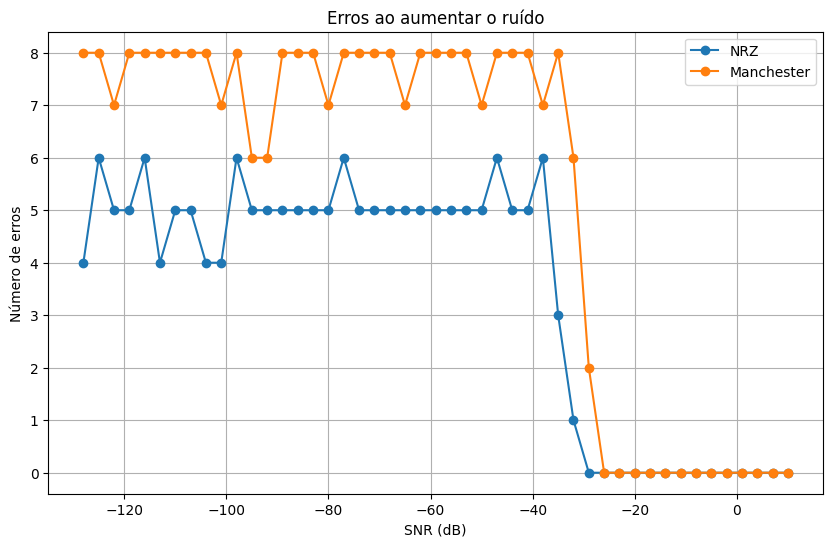

=== NRZ ===
a) Primeiro valor SNR onde pelo menos 1 bit é comprometidos:  -32
b) Valor onde todos os bits são comprometidos:  None
Pelos testes realizados em NRZ, mesmo com SNR muito baixo, o pico de frequência dominante ainda aparece na FFT.
Dessa forma ele é um metodo de detecção extremamente resistente ao ruído. Por isso, é raro que todos os bits sejam comprometidos

=== Manchester ===
a) Primeiro valor SNR onde pelo menos 1 bit é comprometidos:  -29
b) Valor onde todos os bits são comprometidos:  -35
Em níveis extremos de ruido a aleatoriedade pode ocasionalmente gerar transições que coincidem com o padrão esperado,
fazendo com que alguns bits ‘acertem por sorte’. Por isso, às vezes ruídos maiores produzem menos que 8, mesmo após o pico de degradação.


In [ ]:
def detectar_niveis(erros, snrs, total_bits):
    primeira_falha = None
    falha_total = None
    for snr, e in zip(snrs[::-1], erros[::-1]):
        if e > 0 and primeira_falha is None:
            primeira_falha = snr
        if e == total_bits and falha_total is None:
            falha_total = snr
    return primeira_falha, falha_total

original_bits = "00111000"
snr_range = np.arange(-128, 12, 3)

erros_nrz = []
erros_man = []

for snr in snr_range:
    # ===================== NRZ =====================
    clean_nrz = encode_nrz(original_bits)
    noisy_nrz = adicionar_ruido(clean_nrz, snr)
    dec_nrz = decode_nrz(noisy_nrz, len(original_bits))

    erros = sum(1 for a,b in zip(original_bits, dec_nrz) if a != b)
    erros_nrz.append(erros)

    # ===================== MANCHESTER =====================
    clean_man = encode_manchester(original_bits)
    noisy_man = adicionar_ruido(clean_man, snr)
    dec_man = decode_manchester(noisy_man, len(original_bits))

    erros = sum(1 for a,b in zip(original_bits, dec_man) if a != b)
    erros_man.append(erros)


# ===================== GRÁFICO =====================
plt.figure(figsize=(10,6))
plt.plot(snr_range, erros_nrz, '-o', label="NRZ")
plt.plot(snr_range, erros_man, '-o', label="Manchester")
plt.xlabel("SNR (dB)")
plt.ylabel("Número de erros")
plt.title("Erros ao aumentar o ruído")
plt.grid(True)
plt.legend()
plt.show()

nrz_first, nrz_full = detectar_niveis(erros_nrz, snr_range, len(original_bits))
man_first, man_full = detectar_niveis(erros_man, snr_range, len(original_bits))

print("=== NRZ ===")
print("a) Primeiro valor SNR onde pelo menos 1 bit é comprometidos: ", nrz_first)
print("b) Valor onde todos os bits são comprometidos: ", nrz_full)
print("Pelos testes realizados em NRZ, mesmo com SNR muito baixo, o pico de frequência dominante ainda aparece na FFT.\nDessa forma ele é um metodo de detecção extremamente resistente ao ruído. Por isso, é raro que todos os bits sejam comprometidos.")

print("\n=== Manchester ===")
print("a) Primeiro valor SNR onde pelo menos 1 bit é comprometidos: ", man_first)
print("b) Valor onde todos os bits são comprometidos: ", man_full)
print("Em níveis extremos de ruido a aleatoriedade pode ocasionalmente gerar transições que coincidem com o padrão esperado,\nfazendo com que alguns bits ‘acertem por sorte’. Por isso, às vezes ruídos maiores produzem menos que 8, mesmo após o pico de degradação.")